# Predicting Financial Fraud of Firms
## 1.0 Introduction

Firms report financial statements for every quarter and annual period. These statements are first reported internally by the organization, which in turn must be audited by accredited auditing firms to verify that the reports are accurate. Firms may be incentivized to create fraud within their reports for financial benefits such as taxation and value inflation. Fraudulent activity can cause massive monetary loss for investors (Hajek 2017), government organizations (Lin 2015), and individuals (Lin 2015). Fraudulent activity is also increasing (Lin 2015). This marks a growing importance for developing better ways at detecting and eliminating financial fraud.

Our analysis will try to determine if selected variables can form a model to accurately predict whether or not a firm is fraudulent given the predictor variables.

The question we want to answer is: <strong>Can we accurately predict if a financial firm is fraudulent or not based on its reported vs audited monetary discrepancies, money involved in misstatements, and historical monetary loss?</strong>

The dataset that will be used to answer this question is Audit Data. Audit Data contains risk factor classifications and methods used by the external auditing firm. Specifically, the data contains reports from 777 firms from 46 different listings and 14 different sector scores. The variable that the model will be predicting is Risk. The numeric variables in this dataset and Risk are:

<ol>
    <li>Para A : Discrepancy in planned spending in Indian Rupees (in crore) (Hooda 2018)</li>
    <li>Para B : Discrepancy in unplanned spending in Indian Rupees (in crore) (Hooda 2018)</li>
    <li>Total : Sum of discrepancies in Para A and Para B and other reports in Indian Rupees (in crore) (Hooda 2018)</li>
    <li>Number : Historical Discrepancy Score (non-measured) (Hooda 2018)</li>
    <li>Money Value : Amount of money involved in misstatements (Hooda 2018)</li>
    <li>Sector : Historical risk score (non-measured) (Hooda 2018)</li>
    <li>Loss : Monetary loss suffered by a firm in the last year (Hooda 2018)</li>
    <li>History : Average monetary loss by a firm in the last 10 year (Hooda 2018)</li>
    <li>District Score : Risk score of district in last 10 years (non-measured) (Hooda 2018)</li>
    <li>Risk <strong>(predicted fct variable)</strong> : 1 if the firm has been determined to be fraudulent. 0 if not.</li>
</ol>

#### [Figure 1.0]

Some variables were not included because they were enumerations (eg. Audit ID, Location ID) or calculated risk values (eg. ARS or Risk, our predicted variable).

## 1.1 Methods

### 1.11 Choosing Our Predictor Variables from the List

Out of the variables listed, we should not consider District Score, Number, and Sector Score. These values were calculated by analysis of the other variables. It would not make sense to include them because these values are not created when an inspector visits a firm. To make the model more useful, we should use only variables that can be determined from inspection, audits, or historical audits and inspections. That way, our model is more useful since it relies less calculated variables which may not always be present when an audit is performed.

Now that we have ruled out three variables, we are left with Para A and B, Total, Money Value, Loss, and History. When inspecting Para A, Para B, and Total, they all represent discrepancies in reported spending vs audited spending. Discrepancies in reported vs audited spending would be extremely valuable to determine if a firm is fraudulent because false reporting of money spending would likely indicate suspicious activity. Hence, we should include a variable that describes discrepancy in spending. Since Total includes Para A, Para B, and other discrepancies, it makes more sense to only include Total and remove Para A and Para B as predictor variables.

The other variables to choose from are Money Value, Loss, and History. Loss and History both describe a similar measurement: historical monetary loss. This could be valuable to our analysis because a fraudulent firm would likely suffer losses on record because the firm has to commit fraud in order to prevent catastrophic loss, or the firm reports losses when in fact the money went somewhere else. In addition, a firm deemed suspicous, and therefore possibly fraudulent, would be more likely to suffer losses since investors and other business people would be less inclined to work with the firm.

We have decided that the measure of historical monetary loss will be important towards our analysis, but there are still two variables that can be considered within this category: Loss and History. When considering the descriptions for each variable, Loss refers to monetary loss in the last year while History refers to monetary loss in the last 10 years. Based on this, we can say that History is the better choice out of the two because it is less volatile. A firm could have had relatively great loss in the last year but on average gained money in the last 10 years. Hence, we chose History over Loss.

That narrows it down to one varible left: Money Value. Money Value is defined as the amount of money involved in misstatements (Hooda 2018). This value is similar to Total, but it encompasses a measure of money in a different category. Total refers to money involved in discrepancies of reports vs audits, while Money Value measures money in misstatements. This variable will be useful to our analysis because it describes false statements provided from a firm. Hence, we will use this variable alongside the others that we chose to create our model.

To summarize, these are the variables that we will use to create our KNN classification model:

<strong>1. History : Average monetary loss by a firm in the last 10 year (Hooda 2018)</strong>

...

<strong>2. Total : Sum of discrepancies in Para A and Para B and other reports in Indian Rupees (in crore) (Hooda 2018)</strong>

...

<strong>3. Money Value : Amount of money involved in misstatements (Hooda 2018)</strong>

...

<strong>4. Risk : the predicted variable. Factor that is either one or zero. One indicates fraud and zero indicates that the firm has been determined to be non-fraudulent.</strong>

...

### 1.12 Methods

In order to answer our question, an exploration of the data will be performed in order to determine quality variables for use in our analysis. We will create an initial KNN model with our predictor variables which we will use in a cross-validation in order to determine an optimum value of K for the model. Then we will use this value of K to create our final model. Then, we will use the testing data to test how accurate our model is at classifying observations it has not seen. Finally, we will summarize our findings by calculating an accuracy and also displaying a confusion matrix of how well the model was able to predict on the testing data.

### 1.13 Wrangling

First, we load the libraries that we need, which are tidyverse, tidymodels, repr, and GGally.

In [2]:
library(tidyverse)
library(tidymodels)
library(repr)
library(GGally)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

Now we want to download the data from the url. Since it is in .zip format, we have to download it before unzipping and then using read_csv(). The file "audit_risk.csv" is the one with the data that we want to use to create our classification.

In [16]:
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00475/audit_data.zip"
download.file(url, "audit_data.zip")
unzip("audit_data.zip")

audit_risk_data_main <- read_csv("audit_data/audit_risk.csv")

Warning message:
“Duplicated column names deduplicated: 'Score_B' => 'Score_B_1' [11]”
Parsed with column specification:
cols(
  .default = col_double(),
  LOCATION_ID = col_character()
)

See spec(...) for full column specifications.



Before we inspect the data, we should split it up into training and testing data so we are only using the training data during our training portion of the analysis. We set the seed so the split is the same everytime, then use initial_split to perform the split. Next, we extract each respective data set into a training data set and a testing data set.

In [18]:
### SET THE SEED
set.seed(18)
### DO NOT CHANGE

audit_risk_data_split <- initial_split(audit_risk_data_main, prop = 2/3, strata = Risk)
audit_risk_data_training <- training(audit_risk_data_split)
audit_risk_data_testing <- testing(audit_risk_data_split)

Firstly, we should inspect the table to check for poor data quality, tidyness, and trends. We can check the first few rows of the training data.

In [24]:
head(audit_risk_data_training, 12)

Sector_score,LOCATION_ID,PARA_A,Score_A,Risk_A,PARA_B,Score_B,Risk_B,TOTAL,numbers,⋯,RiSk_E,History,Prob,Risk_F,Score,Inherent_Risk,CONTROL_RISK,Detection_Risk,Audit_Risk,Risk
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3.89,6,0.00,0.2,0.000,10.80,0.6,6.480,10.80,6.0,⋯,0.4,0,0.2,0.0,4.4,17.5300,0.4,0.5,3.50600,1
3.89,6,0.00,0.2,0.000,0.08,0.2,0.016,0.08,5.0,⋯,0.4,0,0.2,0.0,2.0,1.4160,0.4,0.5,0.28320,0
3.89,7,1.10,0.4,0.440,7.41,0.4,2.964,8.51,5.0,⋯,0.4,0,0.2,0.0,3.2,31.7740,0.4,0.5,6.35480,1
3.89,8,8.50,0.6,5.100,12.03,0.6,7.218,20.53,5.5,⋯,0.4,0,0.2,0.0,4.2,18.0340,0.4,0.5,3.60680,1
3.89,8,8.40,0.6,5.040,11.05,0.6,6.630,19.45,5.5,⋯,0.4,0,0.2,0.0,4.2,17.2060,0.4,0.5,3.44120,1
3.89,8,3.98,0.6,2.388,0.99,0.2,0.198,4.97,5.0,⋯,0.4,0,0.2,0.0,2.4,4.3720,0.4,0.5,0.87440,0
3.89,8,5.43,0.6,3.258,10.77,0.6,6.462,16.20,5.0,⋯,0.4,0,0.2,0.0,3.6,12.0040,0.4,0.5,2.40080,1
3.89,8,5.47,0.6,3.282,7.63,0.4,3.052,13.10,5.0,⋯,0.4,1,0.4,0.4,3.6,14.3920,0.8,0.5,5.75680,1
3.89,8,1.09,0.4,0.436,0.35,0.2,0.070,1.44,5.0,⋯,0.4,0,0.2,0.0,2.2,1.9060,0.4,0.5,0.38120,0


#### [Table 1.13]. Legend: See [Figure 1.0]

The data appears to be tidy in the columns we can see. Each column is one variable, each row is one observation, and each cell has exactly one value. Out of the 12 rows we are showing, there are no NA values, but let's check to make sure there aren't a massive amount of NAs hiding:

In [123]:
nrow(na.omit(audit_risk_data_training))
nrow(audit_risk_data_training)

[1] 517

[1] 518

The data seems to be of high quality! There is only one row with missing data. Since this observation could just be an irrelevant variable, we should filter out rows with NA values after we choose our predictors so we can keep as many observations as possible. Since we are predicting Risk through classification, we should convert that column to a factor. Let's also do the same for the testing data:

In [83]:
audit_training <- mutate(audit_risk_data_training, Risk = as_factor(Risk))
audit_testing <- mutate(audit_risk_data_testing, Risk = as_factor(Risk))

head(select(audit_training, Risk), 1)

Risk
<fct>
1


### 1.14 Exploring the Data through Tables to Inspect Quality, Inspect Trends, and Determine Variables

There are too many column names, so we should see all the column names and match them with the variables described in the introduction. There are many columns here that are never referenced in the research articles we used, so we can remove them since they are irrelevant to our analysis. Let's check the column names.

In [85]:
colnames(audit_training)

[1] "Sector_score"   "LOCATION_ID"    "PARA_A"         "Score_A"       
 [5] "Risk_A"         "PARA_B"         "Score_B"        "Risk_B"        
 [9] "TOTAL"          "numbers"        "Score_B_1"      "Risk_C"        
[13] "Money_Value"    "Score_MV"       "Risk_D"         "District_Loss" 
[17] "PROB"           "RiSk_E"         "History"        "Prob"          
[21] "Risk_F"         "Score"          "Inherent_Risk"  "CONTROL_RISK"  
[25] "Detection_Risk" "Audit_Risk"     "Risk"

Most of these column names can seemingly be match up with our introduction. We should remove the ones that cannot be matched, or ones that cannot be found in the data but are in our research articles. For example, one of the articles and our introduction mention a Loss variable (Hooda 2018) which is no where to be seen in the data. The only variable similar in name is District_Loss, which refers to something else. The variables we will keep and consider for our model are:
- PARA_A
- PARA_B
- TOTAL
- numbers
- Money_Value
- History
- Risk
- Sector_score.

Notably, we are missing two variables that we originally wanted to inspect for worthiness in our model. These are Loss and District Score. Loss, on inspection of the description, is not an important variable to consider because History is a better form of Loss. Loss refers to monetary loss in the last year, while History refers to monetary loss in the last 10 years. The Loss variable could be somewhat random, while History would be consistent as it is over a longer period of time. Hence, we can discard Loss.

District Score is a calculated value. This would not be a great variable to include because it would have to be calculated before the model could be used. Hence, we can discard District Score.

We can select the columns we want to consider:

In [87]:
audit_consider <- audit_training %>% select(PARA_A, PARA_B, TOTAL, numbers, Money_Value, History, Risk, Sector_score)

head(audit_consider, 12)

PARA_A,PARA_B,TOTAL,numbers,Money_Value,History,Risk,Sector_score
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>
0.00,10.80,10.80,6.0,11.750,0,1,3.89
0.00,0.08,0.08,5.0,0.000,0,0,3.89
1.10,7.41,8.51,5.0,44.950,0,1,3.89
8.50,12.03,20.53,5.5,7.790,0,1,3.89
8.40,11.05,19.45,5.5,7.340,0,1,3.89
3.98,0.99,4.97,5.0,1.930,0,0,3.89
5.43,10.77,16.20,5.0,4.420,0,1,3.89
5.47,7.63,13.10,5.0,10.430,1,1,3.89
1.09,0.35,1.44,5.0,0.000,0,0,3.89


#### [Table 1.14]. Legend: See [Figure 1.0]

From Table 1.14, it is clear that TOTAL, Money_Value, PARA_A, and PARA_B have a relationship with Risk, indicating that these could be possible variables to predict Risk. All the observations with Risk = 1 have a TOTAL >= 8.51 while the max of TOTAL for observations with Risk = 0 in this table is 4.97.

Another thing of notability is the values for PARA_A, PARA_B, and TOTAL. In the rows, TOTAL appears to be the sum of PARA_A and PARA_B. Let's examine this further by creating a new column called AB that is the sum of PARA_A and PARA_B. Then we should check how many rows have TOTAL and AB not equal. Since we are comparing decimals that are vulnerable to floating point error we should compare with an epsilon of 0.1.

In [89]:
audit_total_ne_aplusb <- audit_consider %>%
mutate(AB = PARA_A + PARA_B, equal = (abs(AB - TOTAL) <= 0.1)) %>%
filter(equal == FALSE)

head(audit_total_ne_aplusb, 12)

PARA_A,PARA_B,TOTAL,numbers,Money_Value,History,Risk,Sector_score,AB,equal
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<lgl>
20.65,0,0,6,397.31,1,1,15.56,20.65,FALSE


#### [Table 1.141]. Legend: See [Figure 1.0]

It seems like TOTAL is simply the sum of PARA_A and PARA_B. There is only one observation that has a difference abs(AB - TOTAL) greater than 0.1. This could be an error in the observation or it could be an obscure case. Based on this exploratory analysis of the data, we can conclude that TOTAL is the sum of PARA_A and PARA_B. When inspecting Para A, Para B, and Total, they all represent discrepancies in reported spending vs audited spending. Discrepancies in reported vs audited spending would be extremely valuable to determine if a firm is fraudulent because false reporting of money spending would likely indicate suspicious activity. Hence, we should include a variable that describes discrepancy in spending. Since Total includes Para A, Para B, and other discrepancies, it makes more sense to only include Total and remove Para A and Para B as predictor variables.

#### Visualizing the Training Data to Detect Trends and Find Relevant Variables

Next let's look at Money_Value, another one of the numbers that seemed to have some sort of relationship with Risk. In Table 1.131, high Money_Value values correspond with a Risk value of 1. We can create two histograms, one with the distributions of Money_Value for observations of Risk = 1, and the other with the distributions of Money_Value for observations of Risk = 0.

We can do this by using facet_grid() to create 2 separate histogram distribution plots of Money_Value for Risk == 0 and Risk == 1.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 1 rows containing non-finite values (stat_bin).”


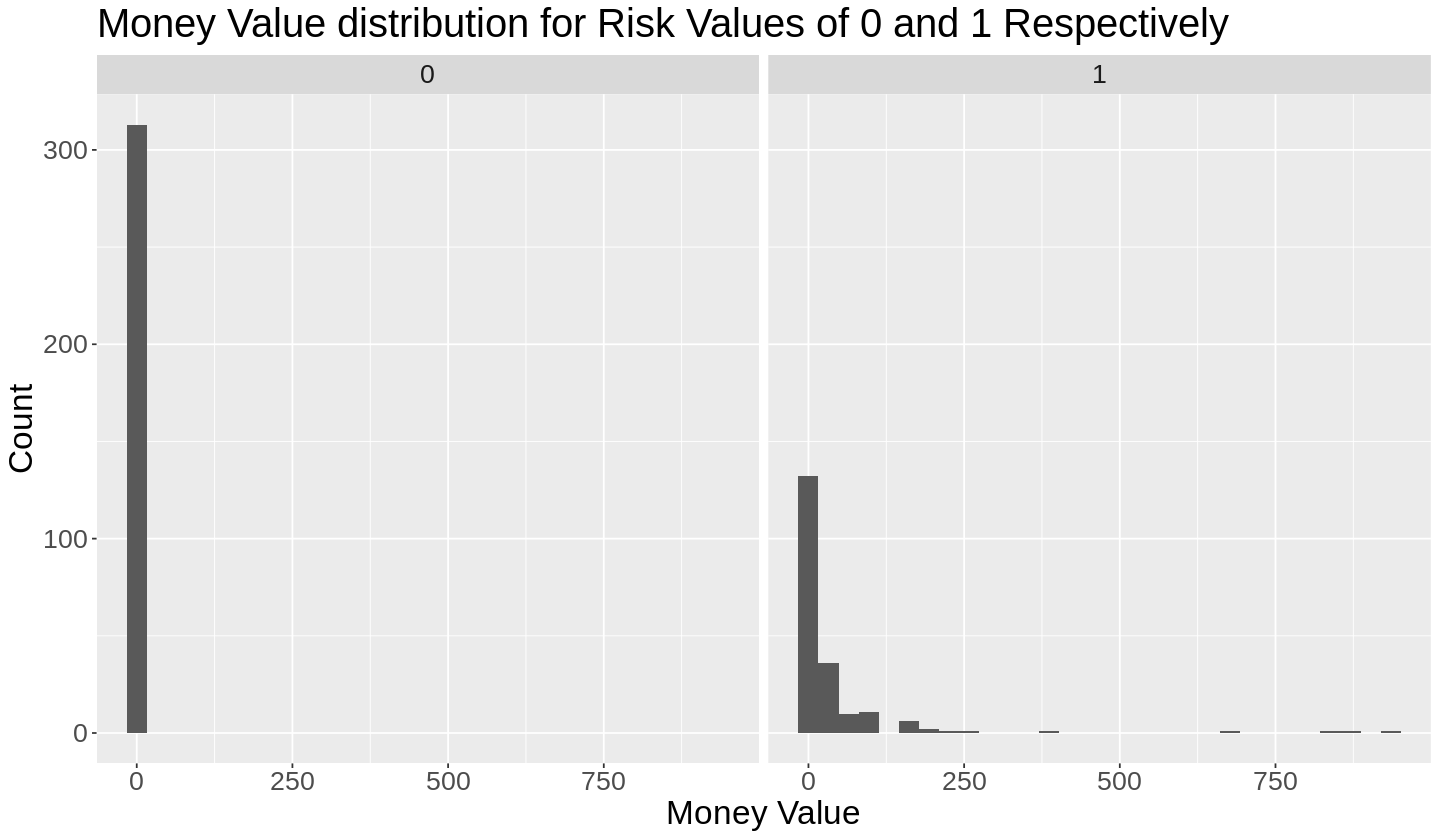

In [100]:
options(repr.plot.width = 12, repr.plot.height = 7)

money_value_plot <- audit_consider %>%
ggplot(aes(x = Money_Value)) +
facet_grid(. ~ Risk) +
geom_histogram() +
labs(x = "Money Value", y = "Count") +
ggtitle("Money Value distribution for Risk Values of 0 and 1 Respectively") +
theme(text = element_text(size = 20))

money_value_plot

#### [Figure 1.142]. Money Value: Amount of Money involved in misstatements (Hooda 2018)

From Figure 1.142, it's pretty clear that Money Values associated with a Risk value of 1 are much higher on average than Money Values associated with a Risk value of 0. We haven't done this for TOTAL yet, so let's do that:

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



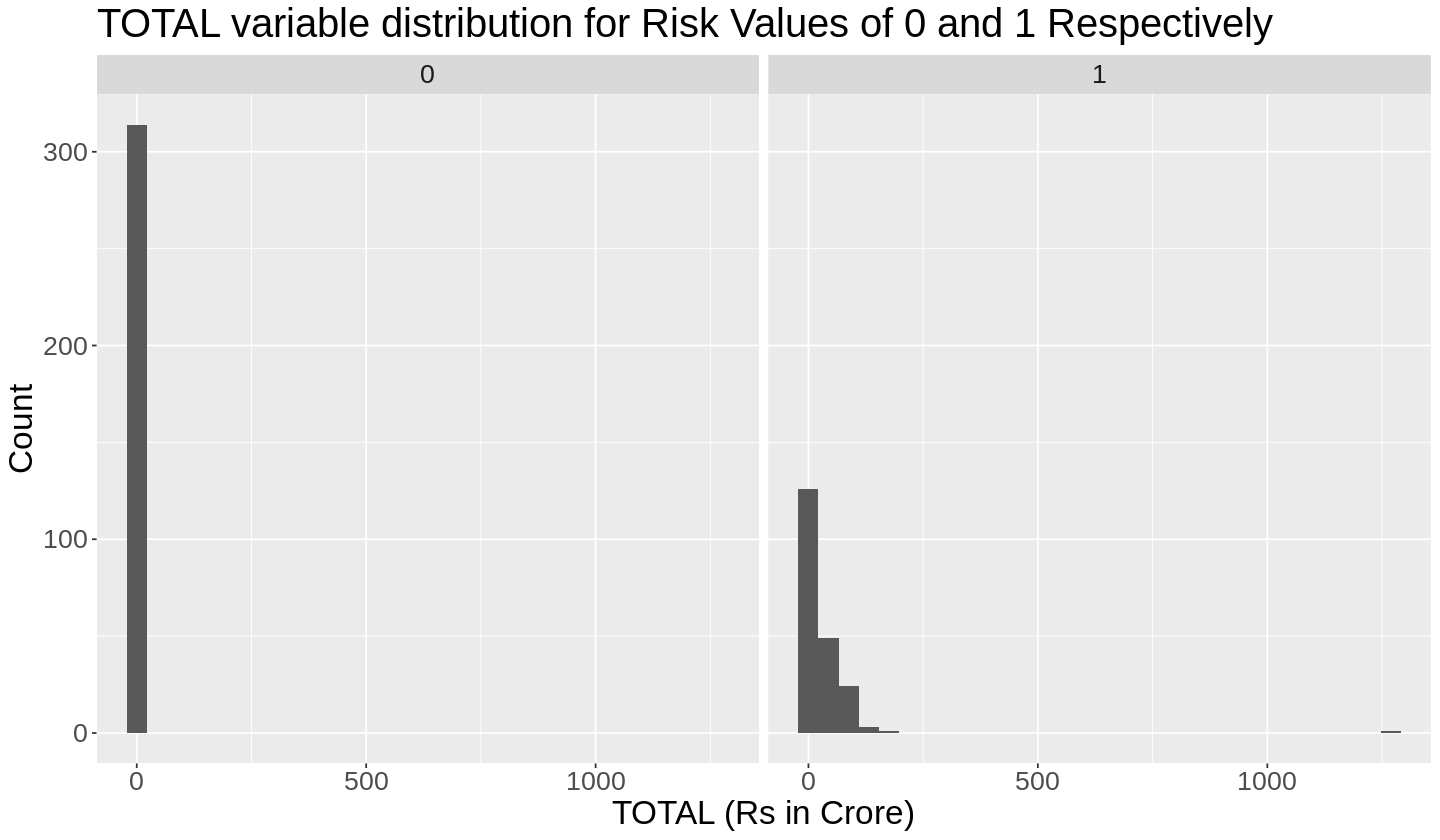

In [118]:
options(repr.plot.width = 12, repr.plot.height = 7)

money_value_plot <- audit_consider %>%
ggplot(aes(x = TOTAL)) +
facet_grid(. ~ Risk) +
geom_histogram() +
labs(x = "TOTAL (Rs in Crore)", y = "Count") +
ggtitle("TOTAL variable distribution for Risk Values of 0 and 1 Respectively") +
theme(text = element_text(size = 20))

money_value_plot

#### [Figure 1.143]. TOTAL: Discrepencies in planned and unplanned spending

From Figure 1.143, there also appears to be an trend. There are much more TOTAL values greater than 0 if Risk == 1. These graphs are somewhat hard to read because of outliers, but we can quantitavely determine if they are good variables by checking their mean for Risk == 0 and Risk == 1. Let's create a mean, min, max, and sd table for each of the variables in Table 1.14, separated by Risk value, to help determine if they would be a good candidate or not:

In [152]:
bind_rows(filter(audit_consider, Risk == 0) %>%
select(-Risk) %>%
map_df(mean, na.rm = TRUE) %>%
mutate(Stat = "Mean", Risk = 0) %>%
bind_rows(audit_consider %>%
         filter(Risk == 0) %>%
         select(-Risk) %>%
         map_df(sd, na.rm = TRUE) %>%
         mutate(Stat = "SD", Risk = 0)),
          
filter(audit_consider, Risk == 0) %>%
          select(-Risk) %>%
          map_df(min, na.rm = TRUE) %>%
          mutate(Stat = "Min", Risk = 0),
          
filter(audit_consider, Risk == 0) %>%
          select(-Risk) %>%
          map_df(max, na.rm = TRUE) %>%
          mutate(Stat = "Max", Risk = 0),
          
          filter(audit_consider, Risk == 1) %>%
          select(-Risk) %>%
          map_df(min, na.rm = TRUE) %>%
          mutate(Stat = "Min", Risk = 1),
          
filter(audit_consider, Risk == 1) %>%
          select(-Risk) %>%
          map_df(max, na.rm = TRUE) %>%
          mutate(Stat = "Max", Risk = 1),

filter(audit_consider, Risk == 1) %>%
select(-Risk) %>%
map_df(mean, na.rm = TRUE) %>%
mutate(Stat = "Mean", Risk = 1) %>%
bind_rows(audit_consider %>%
         filter(Risk == 1) %>%
         select(-Risk) %>%
         map_df(sd, na.rm = TRUE) %>%
         mutate(Stat = "SD", Risk = 1)))

PARA_A,PARA_B,TOTAL,numbers,Money_Value,History,Sector_score,Stat,Risk
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
0.7248408,0.4493433,1.174184,5.00159236,0.3856997,0.003184713,26.792197,Mean,0
0.9624982,0.8833369,1.327482,0.02821663,1.0864456,0.056433265,25.742227,SD,0
0.0000000,0.0000000,0.000000,5.00000000,0.0000000,0.000000000,1.850000,Min,0
5.2000000,7.3700000,7.370000,5.50000000,8.2100000,1.000000000,59.850000,Max,0
0.0000000,0.0000000,0.000000,5.00000000,0.0000000,0.000000000,1.850000,Min,1
85.0000000,1264.6300000,1268.910000,6.50000000,935.0300000,9.000000000,59.850000,Max,1
5.6920127,27.8664706,33.457258,5.12254902,43.3901471,0.284313725,8.323578,Mean,1
9.7573038,91.6450063,92.690083,0.27125211,123.5624716,0.858196654,15.807394,SD,1


#### [Table 1.144]. Legend: See [Figure 1.0]

The means of TOTAL for Risk == 1 and Risk == 0 vary greatly. The mean TOTAL for Risk == 0 is about 1, but it is ~33 for Risk == 1. This supports our choice of TOTAL as a predictor variable because it indicates that TOTAL can be used to determine if a firm is fraudulent or not. Same with Money_Value. The mean for Risk == 0 is about 0.5, while the mean for Risk == 1 is about 43. Using the same reasoning, we can conclude that these two variables are good for our model.

So far, we have ruled out PARA_A and PARA_B and chosen TOTAL and Money_Value. That leaves these possible predictor variables:

- numbers
- Sector_score
- History

Although both numbers and Sector_score appear to be possible predictors, they are both unmeasured quantities. The variable, "numbers," refers to historical discrepancy score, which is non-measured. Sector_score was determined by analysis (Hooda 2018). This rules both of them out.

## Visualizing the Training Data

We should examine the data to see possible trends. We will remove Risk from the data set because we only want to explore the predictor variables and then calculate the mean, median, standard deviation, min, and max to get a general sense of the numbers.

In [55]:
audit_risk_data_training_predictors <- select(audit_risk_data_training, History, TOTAL, Money_Value) ### Select the predictors only

### Now we can calculate the mean, median, min, and max and combine them all into one tibble.

audit_risk_data_training_mean <- audit_risk_data_training_predictors %>%
map_df(mean, na.rm = TRUE) %>%
mutate(Stat = "mean")

audit_risk_data_training_max <- audit_risk_data_training_predictors %>%
map_df(max, na.rm = TRUE) %>%
mutate(Stat = "max")

audit_risk_data_training_min <- audit_risk_data_training_predictors %>%
map_df(min, na.rm = TRUE) %>%
mutate(Stat = "min")

audit_risk_data_training_median <- audit_risk_data_training_predictors %>%
map_df(median, na.rm = TRUE) %>%
mutate(Stat = "median")

audit_risk_data_training_stdev <- audit_risk_data_training_predictors %>%
map_df(sd, na.rm = TRUE) %>%
mutate(Stat = "stdev")

audit_risk_data_training_stats <- bind_rows(audit_risk_data_training_max, audit_risk_data_training_mean,
                                            audit_risk_data_training_min, audit_risk_data_training_median,
                                            audit_risk_data_training_stdev)

audit_risk_data_training_stats

History,TOTAL,Money_Value,Stat
<dbl>,<dbl>,<dbl>,<chr>
9.0000000,1268.91000,935.03000,max
0.1100386,13.95441,16.54841,mean
0.0000000,0.00000,0.00000,min
0.0000000,1.33500,0.11500,median
0.5505893,60.34534,79.30013,stdev


### Analyzing the table

In our table, the max values are very large in comparison to the mean and median.

When comparing the mean to the median, we notice that they are quite far apart. This could indicate that there are not many fraudulent bodies but there are some at the top with very large Money_Value and TOTAL values that raise the mean but do not affect the median by much.

The min indicates that every value can be exactly zero.

<strong>In addition to calculating those stats, we should see how many observations have risk factors of 0 or 1, as well as the total observations.</strong>

In [56]:
audit_risk_data_count <- audit_risk_data_training %>%
group_by(Risk) %>%
summarize(n = n())

audit_risk_data_count

`summarise()` ungrouping output (override with `.groups` argument)



Risk,n
<fct>,<int>
0,314
1,204


There seems to about an even split, which is good because it will provide us with enough samples of each to accurately predict the Risk. The total number of observations in our training data is 518. This should be sufficient to be accurate.

### Creating a Plot

Based on the stats of the previous table, we could plot TOTAL against Money_Value to see if they are correlated. When inspecting the mean/median/stdev table, they appear to have some degree of correlation. It is less clear if History has a correlation with them, but we can plot all three of our predictor variables against each other in a ggpairs matrix in order to examine any possible correlation. Also, we can check the distributions of each variable in the ggpairs plot.

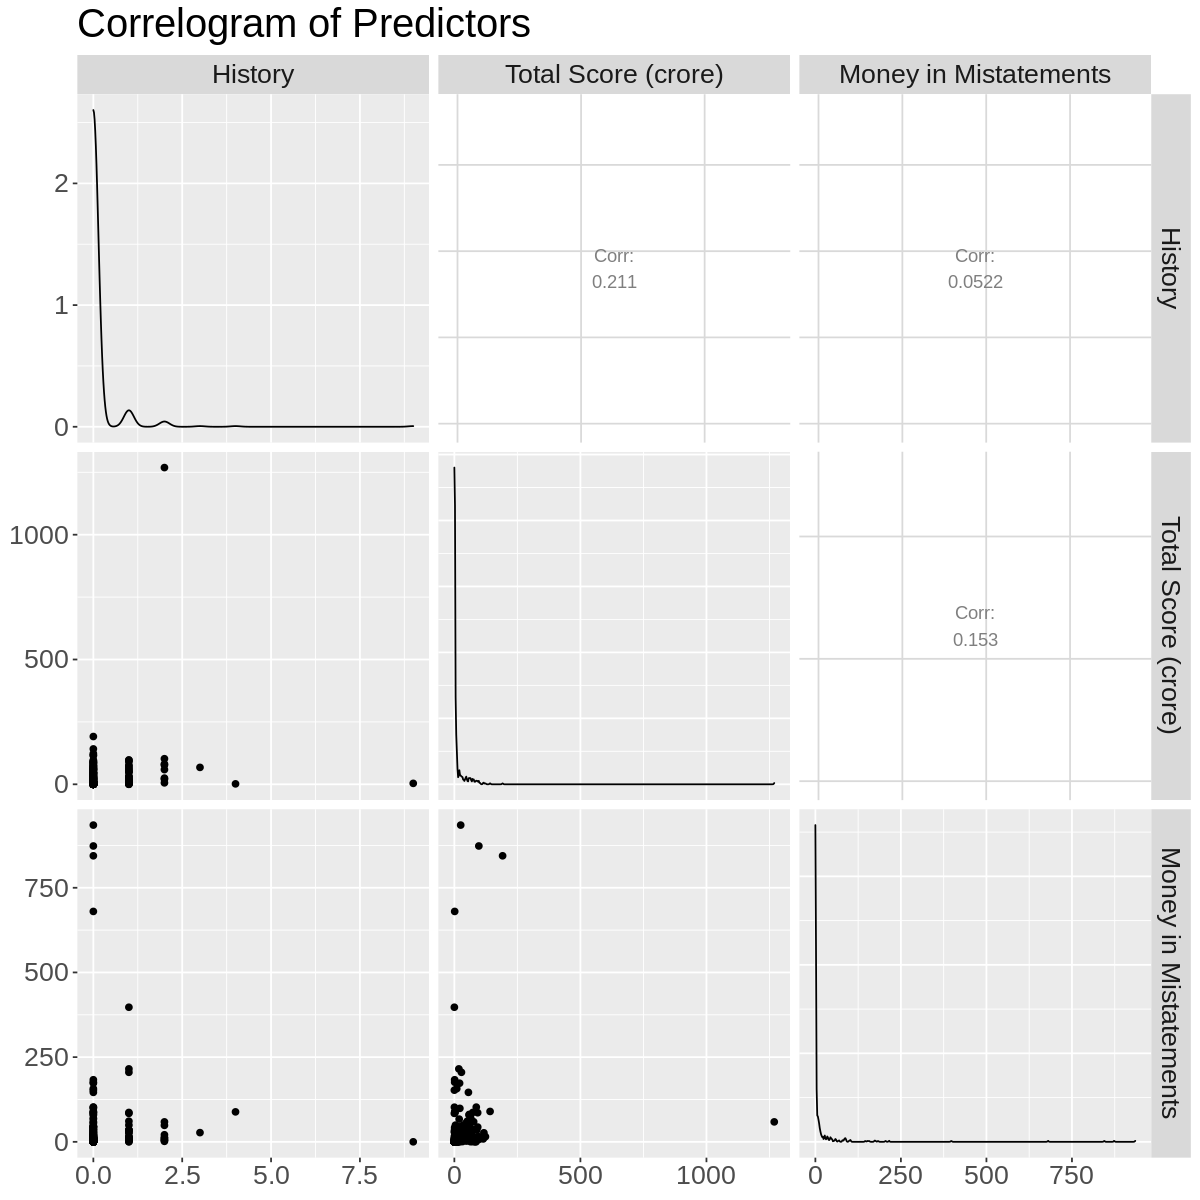

In [57]:
options(repr.plot.width=10, repr.plot.height=10)

audit_risk_data_pairs <- audit_risk_data_training_predictors %>%
ggpairs(columnLabels = c("History", "Total Score (crore)", "Money in Mistatements")) +
theme(text = element_text(size = 20)) +
ggtitle("Correlogram of Predictors")

audit_risk_data_pairs

First, when we look at the correlation values, two have a very weak positive correlation. The correlation between History and TOTAL is the strongest out of the three, but it is still rather weak. History and Money_Value have almost no correlation at all.

When looking at the distributions, they all have very high peaks near 0 and then quickly drop off as the bin numbers increase. This could be an issue if there are not enough neighbors with higher magnitude of predictor variable values to look at during knn classification. However, the ratio of Risk = 0 to Risk = 1 is about 1:1 so there should be enough to do a proper knn classification.

The scatterplots are really hard to read. The History-Total plot and History-Money plot have odd pillars which could indicate that History score is quantized. The Score-Money plot appears to have one outlier which makes the plot extremely difficult to read. When looking at the plots it doesn't appear that any strong correlation can be interpreted, which matches our observations about the Pearson coeff.

## 1.2 Starting the Analysis

We will use K nearest neighbours classification from tidymodels in order to create our classification model. Firstly, we have to find an optimum value of K by cross validation for each K from 1 to 50. To do this we will create a KNN spec that uses tune to create the neighbors and set the engine to KNN and the mode to classification:

In [58]:
audit_knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
set_engine("kknn") %>%
set_mode("classification")

Now we will create a recipe for our data. The predicted variable is Risk and the predictors are the other variables. So we put that as the first argument of recipe(). We should standardize the data because the scales for the variables are very different. For example, History is on a scale from about 0 to ~9, while TOTAL is on a scale of 0 to ~1260. If we did not standardize, then History would have barely any effect because both the other predictors would have a substantially larger effect on the outcome of the classification. Hence, we add the steps center and scale to the recipe.

In [59]:
audit_training <- audit_risk_data_training %>%
select(Risk, History, TOTAL, Money_Value)

audit_training_recipe <- recipe(Risk ~ ., audit_training) %>%
step_center(all_predictors()) %>%
step_scale(all_predictors())

Our final step before we combine these steps into a workflow is to create the vfold_cv object. We will use 5 folds and k values from 1 to 50. The range for k was arbitrarily chosen. If our visualization for the accuracies of various k's shows that there may lie an optimum value of k past 50, then we would have to retry with some larger values of k.

In [60]:
gridvals <- tibble(neighbors = 1:50)
audit_vfold <- vfold_cv(audit_training, C = 5, strata = Risk)

Finally we can combine the spec, recipe, and vfold_cv object in order to do a 5 fold cross validation. Then we will collect the metrics for each K value from 1 to 50 and order them by the accuracy to find the K with the highest accuracy.

First, we will combine the model and the recipe we created. Then we will use tune_grid() to perform the cross validation for all K values 1 to 50. Before using tune_grid() we should set the seed so that it will be reproducible.

In [61]:
set.seed(1015)

audit_training_fit <- workflow() %>%
add_model(audit_knn_spec) %>%
add_recipe(audit_training_recipe) %>%
tune_grid(resamples = audit_vfold, grid = gridvals)

Now we can collect the metrics and then keep only rows that have the metric as accuracy. We will plot the accuracy vs the values of K in order to visually determine which K has the highest accuracy. 

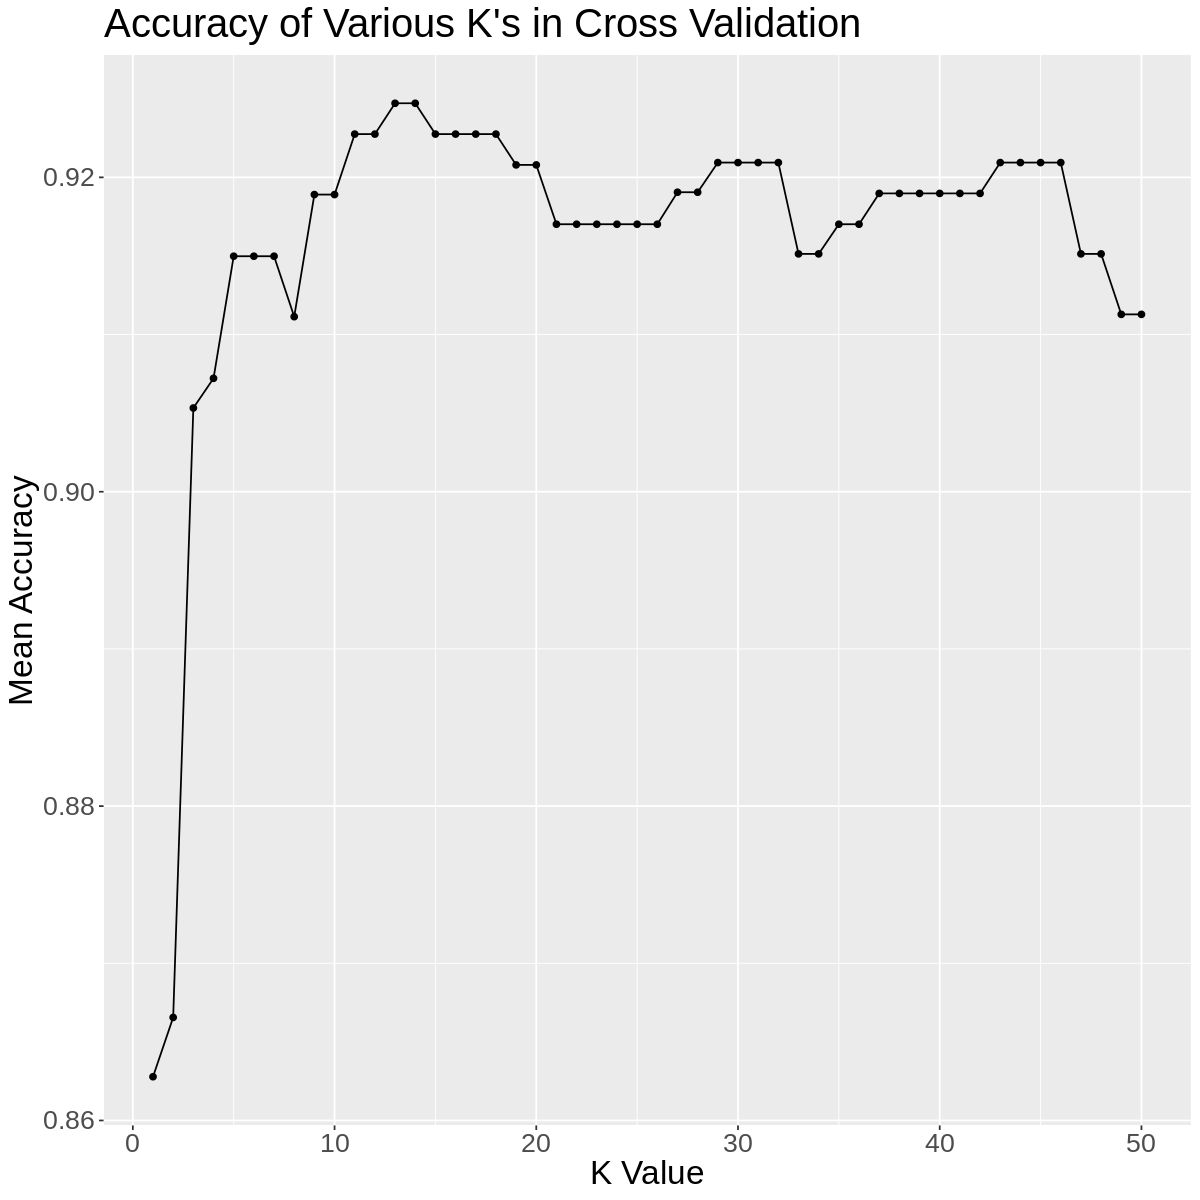

In [62]:
audit_training_metrics <- collect_metrics(audit_training_fit) %>%
filter(.metric == "accuracy")

audit_training_k_plot <- audit_training_metrics %>%
ggplot(aes(x = neighbors, y = mean)) +
geom_point() +
geom_line() +
labs(x = "K Value", y = "Mean Accuracy") +
theme(text = element_text(size = 20)) +
ggtitle("Accuracy of Various K's in Cross Validation")

audit_training_k_plot

Judging from the graph, it appears that we have an optimum K value around 13. However, we should still pick the K with the highest accuracy by sorting the metrics by accuracy descending and then pulling the K value from the head of the data set.

In [64]:
audit_final_k <- audit_training_metrics %>%
arrange(desc(mean)) %>%
select(neighbors) %>%
head(1) %>%
pull()

paste("Final K Value: ", audit_final_k)
audit_final_k_acc <- audit_training_metrics %>%
filter(neighbors == audit_final_k) %>%
select(mean) %>%
pull()

paste("Accuracy: ", audit_final_k_acc)

[1] "Final K Value:  13"

[1] "Accuracy:  0.924713281539031"

We arrive at a K value of 13 with an accuracy of around 92.5%, which is fairly high. Since we used cross validation to determine our K and test our model for K=5, we should have a similar accuracy value for the testing data. Next, we will create our model using the determined K value.

The model and recipe from earlier are combined together, and then the model is fit onto the training data, creating our final fit that we can use to predict the Risk factor.

In [65]:
audit_final_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = audit_final_k) %>%
set_engine("kknn") %>%
set_mode("classification")

audit_final_fit <- workflow() %>%
add_recipe(audit_training_recipe) %>%
add_model(audit_final_spec) %>%
fit(data = audit_training)

## Outcomes and Significance

[...]

# References

Audit Data Set: https://archive.ics.uci.edu/ml/datasets/Audit+Data

Citation Request for Audit Data Set: "This research work is supported by Ministry of Electronics and Information Technology (MEITY), Govt.of India"

Reference format: [First name, Middle name(s), Last name. First Name, Middle name(s), Last Name...etc.] Title. Year of publication. \<link to article\>

eg. Joe, Jones. Google. 1998. www.google.ca

Citation format: (\<Last name of first author\> \<Year of publication\>)

eg. (Obama 1998)

[Chi-Chen, Lin. An-An, Chiu. Shaio, Yan, Huang. David, C., Yen.] Detecting the financial statement fraud: The analysis of the differences between data mining techniques and experts’ judgments. 2015. https://doi.org/10.1016/j.knosys.2015.08.011

[Nishtha, Hooda. Seema, Bawa. Prashant, Singh, Rana.] Fraudulent Firm Classification: A Case Study of an External Audit. 2018. https://doi.org/10.1080/08839514.2018.1451032 => Non pay-walled link:https://www.researchgate.net/publication/323655455_Fraudulent_Firm_Classification_A_Case_Study_of_an_External_Audit

[Petr, Hajek. Roberto, Henriques.] Mining corporate annual reports for intelligent detection of financial statement fraud – A comparative study of machine learning methods. 2017. https://doi.org/10.1016/j.knosys.2017.05.001

[Zabihollah, Rezaee.] Causes, consequences, and deterence of financial statement fraud. 2002.
https://doi.org/10.1016/S1045-2354(03)00072-8